# Interpretable Models

* As a data scientist you are often concerned with fine-tuning models to obtain optimal performance. 
* Data science is often framed as: ‘given data X with labels y, find the model with minimal error’. 
* While the ability to train performant models is a critical skill for a data scientist, it is important to be able to look at the bigger picture. 
* Interpretability of data and machine learning models is one of those aspects that is critical in the practical ‘usefulness’ of a data science pipeline and it ensures that the model is aligned with the problem you want to solve. 
* Although it is easy to lose yourself in experimenting with state-of-the-art techniques when building models, being able to properly interpret your findings is an essential part of the data science process.

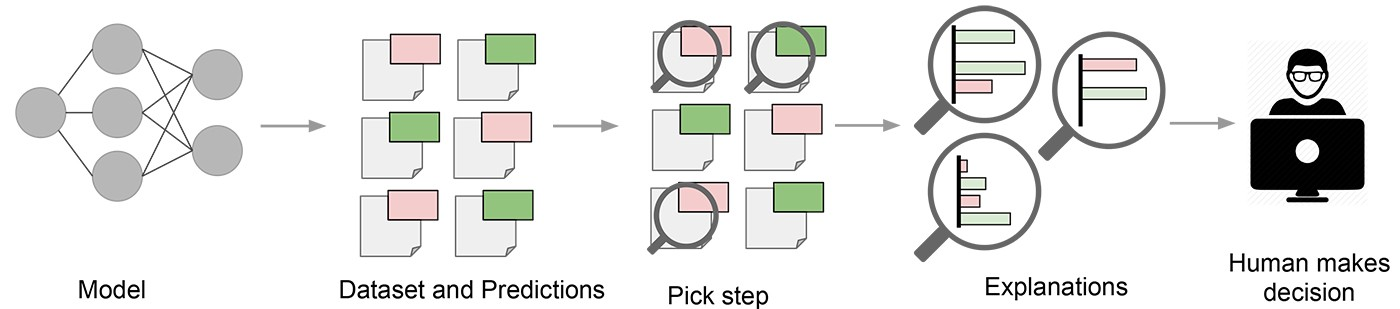

# LIME

* LIME is model-agnostic, meaning that it can be applied to any machine learning model. 
* The technique attempts to understand the model by perturbing the input of data samples and understanding how the predictions change.
* LIME assumes a black box machine learning model and investigates the relationship between input and output, represented by the model.

* LIME provides local model interpretability. 
* LIME modifies a single data sample by tweaking the feature values and observes the resulting impact on the output. 
* Often, this is also related to what humans are interested in when observing the output of a model. 
* **most common question is probably: why was this prediction made or which variables caused the prediction?** 

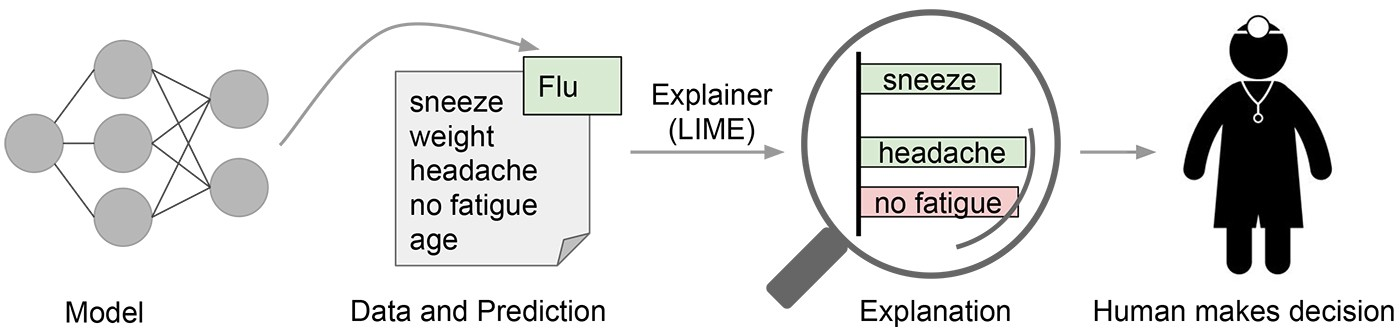

# Intuition behind LIME

* A key requirement for LIME is to work with an interpretable representation of the input, that is understandable to humans. 
* Examples of interpretable representations are e.g. a BoW vector for NLP, or an image for computer vision.
* Dense embeddings on the other hand or not interpretable, and applying LIME probably won’t improve interpretability.
* The output of LIME is a list of explanations, reflecting the contribution of each feature to the prediction of a data sample. 
* This provides local interpretability, and it also allows to determine which feature changes will have most impact on the prediction.

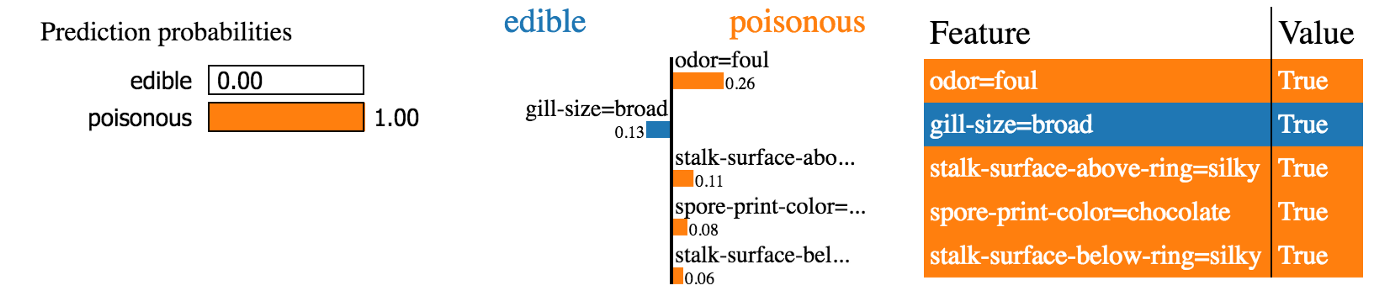

In [ ]:
!pip install lime

     |████████████████████████████████| 275 kB 26.0 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=b09de9dbd0ba501000b2a978e7d59e187ba5767cb2db0f5600fad488f8591878
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


# Applying LIME to Quora dataset and Logistic regression model

* The dataset of the Quora Insincere Questions Classification task. 
* The training data includes the question that was asked, and whether it was identified as insincere.
* Let us look at two questions of this dataset and the corresponding classes (1 for insincere, 0 for sincere question):


> * Insincere question: Why does Trump believe everything that Putin tells him? Is he a communist, or plain stupid?


> * Sincere question: Can the strong correlation between latitude and prosperity be partially explained by another one (if proven to exist) between favourable ambient temperatures and brain enthropy?

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import OrderedDict

In [ ]:
train_df = pd.read_csv(r"/content/drive/MyDrive/My Research/XAI/train.csv")
print("Train shape : ", train_df.shape)

Train shape :  (1306122, 3)


In [ ]:
train_df.sample(5)

qid  \
475609   5d225458d9b809eecfc1   
144071   1c33f013d218d996e191   
1209490  ed0eb572b9b6d86364af   
422513   52d19d303383066ee9f5   
968408   bdbd611ee06950bc34a2   

                                             question_text  target  
475609   My gf of two months is going to be away for a ...       0  
144071         What are the club's main sources of income?       0  
1209490          Will PayPal and Visa partner with Ripple?       0  
422513   Should I start an irrigation business for a su...       0  
968408   Why should I care about the opinions of strang...       0

In [ ]:
df_select = pd.concat([val_df[val_df['qid'] == 'be7afe3c3888bdaf322f'], val_df[val_df['qid'] == 'd61b098340966d9d6501']], axis=0)

In [ ]:
df_select.question_text

972288     When will Quora stop so many utterly stupid qu...
1092525       What is the physical peak a human can achieve?
Name: question_text, dtype: object

In [ ]:
## split to train and val
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=2018)

In [ ]:
val_df.reset_index(drop=True)

qid  \
0       d61b098340966d9d6501   
1       c8d5c445fce3c312ca5f   
2       9177e73a312fb5ff9e43   
3       1ffecf3a38aa5062f51c   
4       daaea60735fcb5f49b12   
...                      ...   
130608  feb0053f32eda8483c9f   
130609  be7afe3c3888bdaf322f   
130610  b0bf236fb7298811f4f6   
130611  4ded8f8f0a7d662bc43e   
130612  64f7c824cc2e2363c8c2   

                                            question_text  target  
0          What is the physical peak a human can achieve?       0  
1             What is the society like in United Kingdom?       0  
2       How should I deal with flight instructors who ...       0  
3       Can you take credit for subconscious acts? And...       0  
4       What master programs are taught in English in ...       0  
...                                                   ...     ...  
130608               How do you define a great spectacle?       0  
130609  When will Quora stop so many utterly stupid qu...       1  
130610    When did commercial jets start using autopilot?       0  
130611          How many hate comments have you received?       0  
130612                       What is meant by formatting?       0  

[130613 rows x 3 columns]

In [ ]:
#val_df.reset_index(drop=True)

In [ ]:
## vectorize to tf-idf vectors
tfidf_vc = TfidfVectorizer(min_df = 10, max_features = 100000, analyzer = "word", ngram_range = (1, 2), stop_words = 'english', lowercase = True)
train_vc = tfidf_vc.fit_transform(train_df["question_text"])
val_vc = tfidf_vc.transform(val_df["question_text"])

In [ ]:
model = LogisticRegression(C = 0.5, solver = "sag")
model = model.fit(train_vc, train_df.target)
val_pred = model.predict(val_vc)

In [ ]:
from sklearn.metrics import f1_score
val_cv = f1_score(val_df.target, val_pred, average = "binary")
print(val_cv)

0.4768372544263886


# LimeTextExplainer

* It is time now to apply LimeTextExplainer function to generate local explanations for predictions. 
* The function needs as parameters the question to explain (of index 130609), the predicted label of the question generated from the black box model (the logistic regression), and the number of features used for explanation.

In [ ]:
idx = val_df.index[130609]

c = make_pipeline(tfidf_vc, model)
class_names = ["sincere", "insincere"]
explainer = LimeTextExplainer(class_names = class_names)
exp = explainer.explain_instance(val_df["question_text"][idx], c.predict_proba, num_features = 10)

print("Question: \n", val_df["question_text"][idx])
print("Probability (Insincere) =", c.predict_proba([val_df["question_text"][idx]])[0, 1])
print("Probability (Sincere) =", c.predict_proba([val_df["question_text"][idx]])[0, 0])
print("True Class is:", class_names[val_df["target"][idx]])

Question: 
 When will Quora stop so many utterly stupid questions being asked here, primarily by the unintelligent that insist on walking this earth?
Probability (Insincere) = 0.7458279590050632
Probability (Sincere) = 0.25417204099493684
True Class is: insincere


In [ ]:
exp.as_list()

[('stupid', 0.36983321425665905),
 ('earth', 0.11343376735618378),
 ('Quora', 0.10199033930414624),
 ('insist', 0.09352504558926107),
 ('questions', 0.07356334235356538),
 ('primarily', -0.07226243106151299),
 ('utterly', 0.039921482456208746),
 ('asked', -0.03702379258159608),
 ('unintelligent', 0.017149501412903077),
 ('walking', -0.0025472049073871133)]

# few visualizations for more understanding

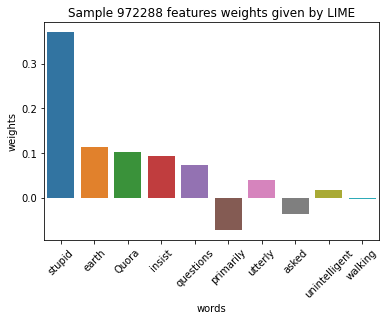

In [ ]:
weights = OrderedDict(exp.as_list())
lime_weights = pd.DataFrame({"words": list(weights.keys()), "weights": list(weights.values())})

sns.barplot(x = "words", y = "weights", data = lime_weights)
plt.xticks(rotation = 45)
plt.title("Sample {} features weights given by LIME".format(idx))
plt.show()

In [ ]:
exp.show_in_notebook(text=False)

In [ ]:
exp.show_in_notebook(text=val_df["question_text"][idx], labels=(1,))

# Remove key words

* These weighted features are a linear model, which approximates the behavior of the logistic regression classifier in the vicinity of the test example. 
* Roughly, if we remove ‘stupid’ and ‘earth’ from the question, the prediction should move towards the opposite class (Sincere) by about 0.48 (the sum of the weights for both features).

In [ ]:
print('Original prediction:',  model.predict_proba(val_vc[130609])[0, 1])
tmp = val_vc[130609].copy()
tmp[0, tfidf_vc.vocabulary_['stupid']] = 0
tmp[0, tfidf_vc.vocabulary_['earth']] = 0
print('Prediction after removing some features:', model.predict_proba(tmp)[0, 1])
print('Difference:', model.predict_proba(tmp)[0, 1] - model.predict_proba(val_vc[130609])[0, 1])

Original prediction: 0.7458279590050632
Prediction after removing some features: 0.33715014712336133
Difference: -0.4086778118817018


# References

In [ ]:
# https://towardsdatascience.com/what-makes-your-question-insincere-in-quora-26ee7658b010
# https://www.kaggle.com/c/quora-insincere-questions-classification/data?select=train.csv
# https://github.com/amamimaha/Explainable-Models/blob/master/Quora%20sincere%20questions.ipynb
# https://towardsdatascience.com/understanding-model-predictions-with-lime-a582fdff3a3b
# https://towardsdatascience.com/interpretability-in-machine-learning-70c30694a05f